In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This colab notebook demonstrates how to read and visualize the data in the Didi dataset: Digital Ink Diagram data.

More information about this data is available at
* https://github.com/google-research/google-research/tree/master/didi_dataset
* [The Didi dataset: Digital Ink Diagram data](https://arxiv.org/abs/2002.09303). P. Gervais, T. Deselaers, E. Aksan, O. Hilliges, 2020.

The colab demonstrates how to:

1. display the data along with the prompt images.
1. convert the data to a sharded `TFRecord` file of `TFExample`s.

In [0]:
from __future__ import division

import collections
import contextlib
import io
import json
import os
import random
import statistics

from googleapiclient.discovery import build
from google.colab import auth
from google.colab import files
from googleapiclient.http import MediaIoBaseDownload
from apiclient import errors

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
from matplotlib import pylab
from IPython.display import Image, display

In [0]:
# Setup and settings.

# Settings
JSON_FILES=["diagrams_wo_text_20200131.ndjson", "diagrams_20200131.ndjson"]
PROJECT_ID = "digital-ink-diagram-data"
BUCKET_NAME = "digital_ink_diagram_data"
LOCAL_DATA_DIR = "/tmp"
NUM_TFRECORD_SHARDS = 1

auth.authenticate_user()

# Creating the service client.
gcs_service = build("storage", "v1")

In [0]:
# Download the data
def download_file_from_gcs(filename):
  directory_name = os.path.join(LOCAL_DATA_DIR, os.path.dirname(filename))
  if not os.path.exists(directory_name):
    os.mkdir(directory_name)
  with open(os.path.join(LOCAL_DATA_DIR, filename), "wb") as f:
    request = gcs_service.objects().get_media(bucket=BUCKET_NAME, object=filename)
    media = MediaIoBaseDownload(f, request)

    done = False
    while not done:
      status, done = media.next_chunk()
      if not done:
        print("Downloading '%s': %-3.0f%%" % (filename, status.progress() * 100))

def get_label_file(type, labelid):
  file_id = os.path.join(type, "%s.%s" % (labelid, type))
  fname = os.path.join(LOCAL_DATA_DIR, file_id)
  if os.path.exists(fname):
    return fname
  download_file_from_gcs(file_id)
  return fname

for json_file in JSON_FILES:
  download_file_from_gcs(json_file)

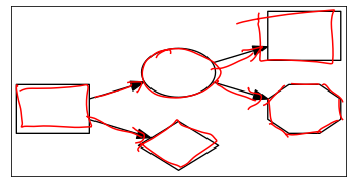

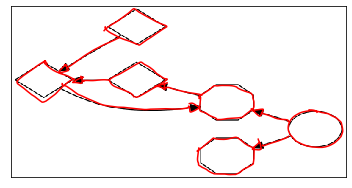

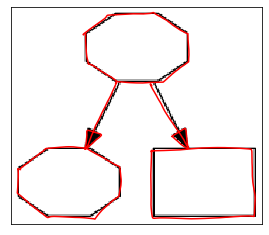

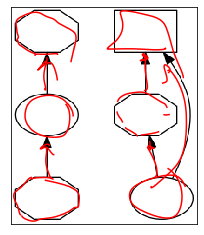

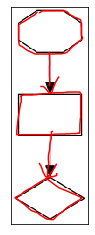

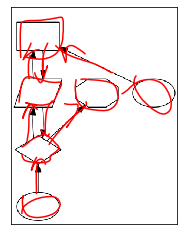

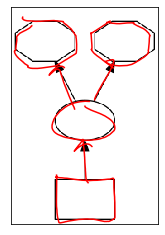

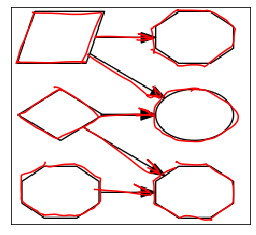

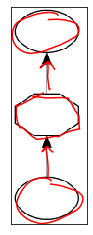

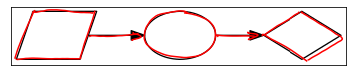

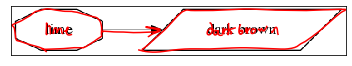

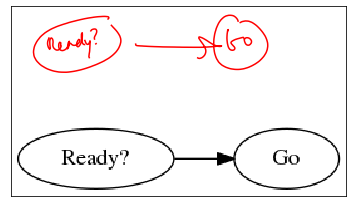

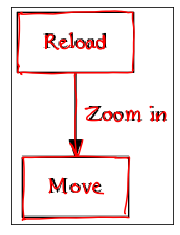

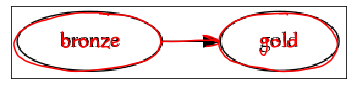

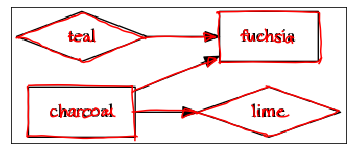

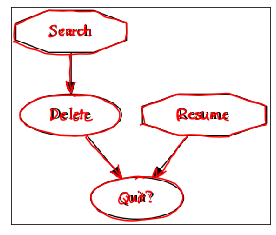

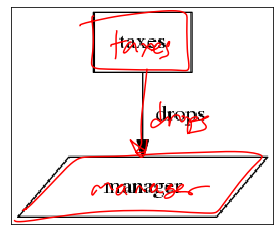

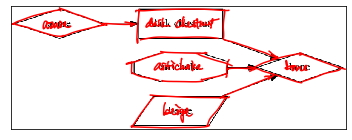

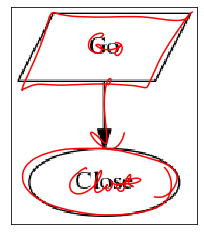

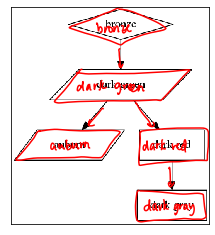

In [0]:
# Displays prompt images with drawing overlaid.
def PrepareDrawing():
  pylab.clf()
  pylab.axes().set_aspect("equal")
  pylab.gca().yaxis.set_visible(False)
  pylab.gca().xaxis.set_visible(False)

def display_image(ink):
  im = pylab.imread(os.path.join(LOCAL_DATA_DIR, "png", ink["label_id"] + ".png"))
  # Compute scaling of the image.
  guide_width = ink["writing_guide"]["width"]
  guide_height = ink["writing_guide"]["height"]
  im_height, im_width, _ = im.shape
  scale=min(guide_width / im_width, guide_height / im_height)
  offset_x = (guide_width - scale * im_width) / 2
  offset_y = (guide_height - scale * im_height) / 2
  pylab.imshow(im, origin="upper",
               extent=(offset_x, offset_x + scale * im_width,
                       offset_y + scale * im_height, offset_y),
                       aspect="equal")

def display_strokes(ink):
  for s in ink["drawing"]:
    pylab.plot(s[0], [y for y in s[1]], color="red")

def display_ink(ink):
  # Fetch the corresponding PNG image.
  get_label_file("png", ink["label_id"])
  # Draw image, overlay strokes.
  PrepareDrawing()
  display_image(ink)
  display_strokes(ink)
  pylab.show()

for json_file in JSON_FILES:
  count = 0
  with open(os.path.join(LOCAL_DATA_DIR, json_file)) as f:
    for line in f:
      ink = json.loads(line)
      display_ink(ink)

      count += 1
      if count == 10:
        break

In [0]:
# This cell converts the file to tf.Record of tf.Example.
# This cell takes long time to run.

def get_label_file_contents(type, labelid):
  get_label_file(type, labelid)
  with open(os.path.join(LOCAL_DATA_DIR, type, "%s.%s" %(labelid, type))) as f:
    return f.read()

def ink_to_tfexample(ink, dot=None):
  """Takes a LabeledInk and outputs a TF.Example with stroke information.

  Args:
    ink: A JSON array containing the drawing information.
    dot: (Optional) textual content of the GrahViz dotfile that was used to
      generate the prompt image.

  Returns:
    a Tensorflow Example proto with the drawing data.
  """
  features = {}
  features["key"] = tf.train.Feature(
      bytes_list=tf.train.BytesList(value=[ink["key"].encode("utf-8")]))
  features["label_id"] = tf.train.Feature(
      bytes_list=tf.train.BytesList(value=[ink["label_id"].encode("utf-8")]))
  if dot:
    features["label_dot"] = tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[dot.encode("utf-8")]))

  max_len = np.array([len(stroke[0]) for stroke in ink["drawing"]]).max()

  strokes = []
  stroke_lengths = []
  for stroke in ink["drawing"]:
    stroke_len = len(stroke[0])
    padded_stroke_with_pen = np.zeros([1, max_len, 4], dtype=np.float32)
    padded_stroke_with_pen[0, 0:stroke_len, 0] = stroke[0]
    padded_stroke_with_pen[0, 0:stroke_len, 1] = stroke[1]
    padded_stroke_with_pen[0, 0:stroke_len, 2] = stroke[2]
    padded_stroke_with_pen[0, stroke_len - 1, 3] = 1
    strokes.append(padded_stroke_with_pen)
    stroke_lengths.append(stroke_len)

  all_strokes = np.concatenate(strokes, axis=0).astype(float)  # (num_strokes, max_len, 4)
  all_stroke_lengths = np.array(stroke_lengths).astype(int)

  features["ink"] = tf.train.Feature(
      float_list=tf.train.FloatList(value=all_strokes.flatten()))
  features["stroke_length"] = tf.train.Feature(
      int64_list=tf.train.Int64List(value=all_stroke_lengths))
  features["shape"] = tf.train.Feature(
      int64_list=tf.train.Int64List(value=all_strokes.shape))
  features["num_strokes"] = tf.train.Feature(
      int64_list=tf.train.Int64List(value=[len(ink["drawing"])]))
  example = tf.train.Example(features=tf.train.Features(feature=features))
  return example

@contextlib.contextmanager
def create_tfrecord_writers(output_file, num_output_shards):
  writers = collections.defaultdict(list)
  for split in ["train", "valid", "test"]:
    for i in range(num_output_shards):
      writers[split].append(
          tf.io.TFRecordWriter("%s-%s-%05i-of-%05i" %
                                      (output_file, split, i, num_output_shards)))
  try:
    yield writers
  finally:
    for split in ["train", "valid", "test"]:
      for w in writers[split]:
        w.close()

def pick_output_shard(num_shards):
  return random.randint(0, num_shards - 1)

def size_normalization(drawing):
  def get_bounding_box(drawing):
    minx = 99999
    miny = 99999
    maxx = 0
    maxy = 0

    for s in drawing:
      minx = min(minx, min(s[0]))
      maxx = max(maxx, max(s[0]))
      miny = min(miny, min(s[1]))
      maxy = max(maxy, max(s[1]))
    return (minx, miny, maxx, maxy)

  bb = get_bounding_box(drawing)
  width, height = bb[2] - bb[0], bb[3] - bb[1]
  offset_x, offset_y = bb[0], bb[1]
  if height < 1e-6:
    height = 1

  size_normalized_drawing = [[[(x - offset_x) / height for x in stroke[0]],
                              [(y - offset_y) / height for y in stroke[1]],
                              [t for t in stroke[2]]]
                             for stroke in drawing]

  return size_normalized_drawing

def resample_ink(drawing, timestep):
  def resample_stroke(stroke, timestep):
    def interpolate(t, t_prev, t_next, v0, v1):
      d0 = abs(t-t_prev)
      d1 = abs(t-t_next)
      dist_sum = d0 + d1
      d0 /= dist_sum
      d1 /= dist_sum
      return d1 * v0 + d0 * v1

    x,y,t = stroke
    if len(t) < 3:
      return stroke
    r_x, r_y, r_t = [x[0]], [y[0]], [t[0]]
    final_time = t[-1]
    stroke_time = final_time - t[0]
    necessary_steps = int(stroke_time / timestep)

    i = 1
    current_time = t[i]
    while current_time < final_time:
      current_time += timestep
      while i < len(t) - 1 and current_time > t[i]:
        i += 1
      r_x.append(interpolate(current_time, t[i-1], t[i], x[i-1], x[i]))
      r_y.append(interpolate(current_time, t[i-1], t[i], y[i-1], y[i]))
      r_t.append(interpolate(current_time, t[i-1], t[i], t[i-1], t[i]))
    return [r_x, r_y, r_t]

  resampled = [resample_stroke(s, timestep) for s in drawing]
  return resampled

for json_file in JSON_FILES:
  counts = collections.defaultdict(int)
  with create_tfrecord_writers(os.path.join(LOCAL_DATA_DIR, json_file + ".tfrecord"), NUM_TFRECORD_SHARDS) as writers:
    with open(os.path.join(LOCAL_DATA_DIR, json_file)) as f:
      for line in f:
        ink = json.loads(line)
        dot = get_label_file_contents("dot", ink["label_id"])
        ink["drawing"] = size_normalization(ink["drawing"])
        ink["drawing"] = resample_ink(ink["drawing"], 20)

        example = ink_to_tfexample(ink, dot)
        counts[ink["split"]] += 1
        writers[ink["split"]][pick_output_shard(NUM_TFRECORD_SHARDS)].write(example.SerializeToString())

  print ("Finished writing: %s train: %i valid: %i test: %i" %(json_file, counts["train"], counts["valid"], counts["test"]))

Finished writing: diagrams_wo_text_20200131.ndjson train: 27278 valid: 4545 test: 4545
Finished writing: diagrams_20200131.ndjson train: 16717 valid: 2785 test: 2785


In [0]:
# Download the TFRecord files to local machine (or use the filemanager on the left).
for json_file in JSON_FILES:
  for split in ["train", "valid", "test"]:
    for i in range(NUM_TFRECORD_SHARDS):
      filename = os.path.join(LOCAL_DATA_DIR, json_file + ".tfrecord-%s-%05i-of-%05i" % (split, i, NUM_TFRECORD_SHARDS))
      print(filename)
      files.download(filename)

In [13]:
stats = {}

# Compute some dataset statistics
def count_points_strokes(ink):
  return sum([len(stroke[0]) for stroke in ink]), len(ink)

# Collect data to compute statistics
for json_file in JSON_FILES:
  stats[json_file] = collections.defaultdict(list)
  with open(os.path.join(LOCAL_DATA_DIR, json_file)) as f:
    for line in f:
      ink = json.loads(line)
      points, strokes = count_points_strokes(ink["drawing"])
      stats[json_file]["points"].append(points)
      stats[json_file]["strokes"].append(strokes)
      stats[json_file]["labels"].append(ink["label_id"])

  print (json_file)
  for i in ["points", "strokes"]:
    print (i, min(stats[json_file][i]), max(stats[json_file][i]), statistics.median(stats[json_file][i]))

  for i in ["labels"]:
    labels, counts = np.unique(stats[json_file][i], return_counts=True)
    print (i, len(labels), min(counts), max(counts), statistics.median(counts))
  print()

diagrams_wo_text_20200131.ndjson
points 2 17980 1068.0
strokes 1 71 9.0
labels 940 1 169 36.0

diagrams_20200131.ndjson
points 2 7268 2295
strokes 1 161 31
labels 5629 1 27 3

